# SRWE Feature Representation Optimization & Classification Failure Diagnosis

This notebook demonstrates the **Spectral Recovery via Walk Embeddings (SRWE)** methodology for graph-level prediction tasks. It:

1. **Recomputes** normalized adjacency eigendecomposition from graph data
2. **Recovers** spectral weights using Tikhonov-regularized Vandermonde recovery
3. **Computes** 5 SRWE feature representations (histogram, raw_weights, eigenvalue_pairs, moment_correction, spectral_summary)
4. **Trains** a GPS-lite GNN (2-layer GCN + attention pooling) with each PE type
5. **Compares** PE representations via screening on the ZINC-subset dataset

Data: A curated subset of 90 ZINC molecular graphs with diverse target values.

In [1]:
# ── Install dependencies ──
import subprocess, sys

def pip_install(*pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + list(pkgs))

# Check if running in Colab
_in_colab = "google.colab" in sys.modules

# Packages needed (NOT pre-installed in Colab)
pip_install("psutil", "loguru")

# Packages that ARE pre-installed in Colab — install at Colab-pinned versions outside Colab
if not _in_colab:
    pip_install(
        "numpy<2", "scipy", "scikit-learn", "torch", "matplotlib"
    )


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# ── Imports ──
import json
import math
import os
import time
import warnings
from dataclasses import dataclass, field
from typing import Any, Optional

import numpy as np
import scipy.stats
from scipy.linalg import eigh
from sklearn.linear_model import Ridge
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

print("Imports OK")
print(f"PyTorch: {torch.__version__}")
print(f"NumPy: {np.__version__}")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Imports OK
PyTorch: 2.10.0+cu128
NumPy: 1.26.4
Device: cuda


In [3]:
# ── Data loading helper ──
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-ace67e-the-walk-resolution-limit-a-super-resolu/main/experiment_iter5_srwe_feature_re/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
for ds in data["datasets"]:
    print(f"Dataset: {ds['dataset']}, Examples: {len(ds['examples'])}")

Dataset: ZINC-subset, Examples: 90


## Configuration

All tunable parameters are defined here. These are set to minimal values for fast demo execution.

In [5]:
# ── Config: tunable parameters ──
# (Original values shown in comments; demo uses reduced values for speed)

RWSE_DIM = 20                        # Original: 20
PE_DIM = 20                          # Original: 20
SCREENING_LAMBDA = 1e-3              # Original: 1e-3

# Feature representation dimensions
HIST_BINS = 20                       # Original: 20
RAW_WEIGHTS_K = 16                   # Original: 16
EIGPAIR_K = 8                        # Original: 8
SPECTRAL_SUMMARY_DIM = 12           # Original: 12

# SRWE histogram range
SRWE_HIST_RANGE = (-1.0, 1.0)

# GNN config
GNN_HIDDEN = 64                      # Original: 64
GNN_LAYERS = 2                       # Original: 2
GNN_DROPOUT = 0.1                    # Original: 0.1
GNN_LR = 1e-3                        # Original: 1e-3
GNN_WD = 1e-5                        # Original: 1e-5
GNN_BATCH_SIZE = 64                  # Original: 64
GNN_MAX_EPOCHS = 150                 # Original: 150
GNN_PATIENCE = 30                    # Original: 30

# Seeds for reproducibility
SEEDS = [0]                          # Original: [0, 1, 2]

# Max examples per dataset (0 = all)
MAX_EXAMPLES = 0                     # Original: 0

print("Config loaded.")

Config loaded.


## Data Structures & Parsing

Define the `GraphData` dataclass and parsing functions that convert raw JSON examples into structured graph objects.

In [6]:
@dataclass
class GraphData:
    """Parsed graph data from the JSON dataset."""
    edge_index: np.ndarray       # [2, E] int
    num_nodes: int
    node_feat: np.ndarray        # [N, F]
    eigenvalues_A: np.ndarray    # from adjacency (stored)
    rwse: np.ndarray             # [N, 20]
    local_spectral_stored: list  # stored top-10 from A
    sri_k20: float
    delta_min: float
    target: Any
    task_type: str
    fold: int
    dataset: str
    row_index: int
    eigenvalues_P: Optional[np.ndarray] = None
    eigenvectors_P: Optional[np.ndarray] = None
    srwe_weights: Optional[dict] = None
    pe_cache: dict = field(default_factory=dict)
    predictions: dict = field(default_factory=dict)
    recovery_metrics: dict = field(default_factory=dict)
    input_str: str = ""
    output_str: str = ""


def parse_graph(example: dict, dataset_name: str) -> Optional[GraphData]:
    """Parse a single example from the dataset JSON into a GraphData object."""
    try:
        inp = json.loads(example["input"])
        edge_index_raw = inp.get("edge_index", [[], []])
        num_nodes = inp.get("num_nodes", 0)
        if num_nodes == 0:
            return None

        edge_index = np.array(edge_index_raw, dtype=np.int64)
        if edge_index.shape[0] != 2:
            edge_index = np.zeros((2, 0), dtype=np.int64)

        node_feat_raw = inp.get("node_feat", [[0]] * num_nodes)
        node_feat = np.array(node_feat_raw, dtype=np.float32)
        if node_feat.ndim == 1:
            node_feat = node_feat.reshape(-1, 1)

        spectral = inp.get("spectral", {})
        eigenvalues_A = np.array(spectral.get("eigenvalues", []), dtype=np.float64)
        rwse_raw = spectral.get("rwse", [])
        local_spectral = spectral.get("local_spectral", [])
        sri = spectral.get("sri", {})
        sri_k20 = float(sri.get("K=20", 0.0))
        delta_min = float(spectral.get("delta_min", 0.0))

        if len(rwse_raw) == 0:
            rwse = np.zeros((num_nodes, RWSE_DIM), dtype=np.float64)
        else:
            rwse = np.array(rwse_raw, dtype=np.float64)
            if rwse.ndim == 1:
                rwse = rwse.reshape(1, -1)
            if rwse.shape[0] < num_nodes:
                pad = np.zeros((num_nodes - rwse.shape[0], rwse.shape[1]), dtype=np.float64)
                rwse = np.vstack([rwse, pad])
            if rwse.shape[1] < RWSE_DIM:
                pad = np.zeros((rwse.shape[0], RWSE_DIM - rwse.shape[1]), dtype=np.float64)
                rwse = np.hstack([rwse, pad])
            elif rwse.shape[1] > RWSE_DIM:
                rwse = rwse[:, :RWSE_DIM]

        return GraphData(
            edge_index=edge_index, num_nodes=num_nodes, node_feat=node_feat,
            eigenvalues_A=eigenvalues_A, rwse=rwse,
            local_spectral_stored=local_spectral,
            sri_k20=sri_k20, delta_min=delta_min,
            target=example["output"],
            task_type=example.get("metadata_task_type", "regression"),
            fold=example.get("metadata_fold", 0),
            dataset=dataset_name,
            row_index=example.get("metadata_row_index", 0),
            input_str=example["input"], output_str=example["output"],
        )
    except Exception as e:
        print(f"Failed to parse graph in {dataset_name}: {e}")
        return None


def load_graphs_from_data(data: dict) -> dict:
    """Load all datasets from the loaded JSON data."""
    datasets = {}
    for ds in data.get("datasets", []):
        ds_name = ds["dataset"]
        examples = ds.get("examples", [])
        graphs = []
        for ex in examples:
            if MAX_EXAMPLES > 0 and len(graphs) >= MAX_EXAMPLES:
                break
            g = parse_graph(ex, ds_name)
            if g is not None:
                graphs.append(g)
        datasets[ds_name] = graphs
        print(f"  {ds_name}: {len(graphs)} graphs parsed")
    return datasets

# Parse the data
all_datasets = load_graphs_from_data(data)
total_graphs = sum(len(v) for v in all_datasets.values())
print(f"\nTotal graphs loaded: {total_graphs}")

  ZINC-subset: 90 graphs parsed

Total graphs loaded: 90


## Phase 1: Spectral Recomputation

Recompute the normalized adjacency eigendecomposition P = D^{-1/2} A D^{-1/2} for each graph, and verify consistency with the stored RWSE values.

In [7]:
def build_adjacency(edge_index: np.ndarray, num_nodes: int) -> np.ndarray:
    """Build dense adjacency matrix from edge_index [2, E]."""
    A = np.zeros((num_nodes, num_nodes), dtype=np.float64)
    if edge_index.shape[1] > 0:
        src, dst = edge_index[0], edge_index[1]
        valid = (src < num_nodes) & (dst < num_nodes) & (src >= 0) & (dst >= 0)
        A[src[valid], dst[valid]] = 1.0
    A = np.maximum(A, A.T)
    np.fill_diagonal(A, 0)
    return A


def compute_normalized_adjacency_eigen(A: np.ndarray) -> tuple:
    """Compute eigendecomposition of P = D^{-1/2} A D^{-1/2}."""
    n = A.shape[0]
    if n == 0:
        return np.array([]), np.array([]).reshape(0, 0)
    degree = A.sum(axis=1)
    d_inv_sqrt = np.zeros(n, dtype=np.float64)
    mask = degree > 1e-12
    d_inv_sqrt[mask] = 1.0 / np.sqrt(degree[mask])
    P = A * d_inv_sqrt[:, None] * d_inv_sqrt[None, :]
    eigenvalues, eigenvectors = eigh(P)
    return eigenvalues, eigenvectors


def recompute_spectral(graph: GraphData, max_nodes: int = 300) -> None:
    """Recompute normalized adjacency eigendecomposition for a graph."""
    if graph.num_nodes > max_nodes:
        graph.eigenvalues_P = graph.eigenvalues_A.copy()
        if len(graph.eigenvalues_P) > 0:
            max_abs = np.max(np.abs(graph.eigenvalues_P))
            if max_abs > 1e-12:
                graph.eigenvalues_P = graph.eigenvalues_P / max_abs
        graph.eigenvectors_P = None
        return
    A = build_adjacency(graph.edge_index, graph.num_nodes)
    eigenvalues_P, eigenvectors_P = compute_normalized_adjacency_eigen(A)
    graph.eigenvalues_P = eigenvalues_P
    graph.eigenvectors_P = eigenvectors_P


def consistency_check(graphs: list, n_samples: int = 5) -> dict:
    """Check consistency between stored RWSE and reconstructed moments from P."""
    errors = []
    for g in graphs[:min(10, len(graphs))]:
        if g.eigenvalues_P is None or g.eigenvectors_P is None:
            continue
        n = g.num_nodes
        n_check = min(n_samples, n)
        for u in range(n_check):
            weights_P = g.eigenvectors_P[u, :] ** 2
            evals_P = g.eigenvalues_P
            for k_idx in range(min(5, RWSE_DIM)):
                k = k_idx + 1
                reconstructed = np.sum(weights_P * (evals_P ** k))
                stored = g.rwse[u, k_idx]
                if abs(stored) > 1e-8:
                    rel_err = abs(reconstructed - stored) / abs(stored)
                else:
                    rel_err = abs(reconstructed - stored)
                errors.append(rel_err)
    mean_err = float(np.mean(errors)) if errors else 0.0
    max_err = float(np.max(errors)) if errors else 0.0
    return {"mean_relative_error": mean_err, "max_relative_error": max_err, "n_checks": len(errors)}


# Run spectral recomputation
t0 = time.time()
skipped_large = 0
for ds_name, graphs in all_datasets.items():
    for g in graphs:
        try:
            recompute_spectral(g)
            if g.eigenvectors_P is None:
                skipped_large += 1
        except Exception as e:
            print(f"Failed spectral recompute: {e}")

print(f"Spectral recomp done in {time.time()-t0:.2f}s ({skipped_large} large graphs used fallback)")

# Consistency check
all_graphs = [g for gs in all_datasets.values() for g in gs]
consistency = consistency_check(all_graphs)
print(f"Consistency: mean_rel_error={consistency['mean_relative_error']:.6f}, "
      f"max={consistency['max_relative_error']:.6f}, n_checks={consistency['n_checks']}")

Spectral recomp done in 0.01s (0 large graphs used fallback)
Consistency: mean_rel_error=0.000001, max=0.000026, n_checks=250


## Phase 2: Tikhonov SRWE Recovery

Recover spectral weights using Tikhonov-regularized Vandermonde inversion. This solves w* = (V^T V + λI)^{-1} V^T m for each node's RWSE moment vector.

In [8]:
def compute_srwe_for_graph(graph: GraphData, lam: float) -> np.ndarray:
    """Compute SRWE weights for all nodes in a graph at a given lambda.
    Optimized: precompute Vandermonde and factorize once, then batched solve."""
    n = graph.num_nodes
    evals = graph.eigenvalues_P
    if evals is None or len(evals) == 0:
        return np.zeros((n, 1), dtype=np.float64)

    n_eigs = len(evals)
    K = min(graph.rwse.shape[1], RWSE_DIM)

    V = np.zeros((K, n_eigs), dtype=np.float64)
    for k in range(K):
        V[k, :] = evals ** (k + 1)

    VtV = V.T @ V
    A_reg = VtV + lam * np.eye(n_eigs)
    M = graph.rwse[:, :K]
    B = V.T @ M.T

    try:
        W = np.linalg.solve(A_reg, B)
    except np.linalg.LinAlgError:
        try:
            W = np.linalg.lstsq(A_reg, B, rcond=None)[0]
        except Exception:
            return np.ones((n, n_eigs), dtype=np.float64) / max(n_eigs, 1)

    weights = W.T
    weights = np.maximum(weights, 0.0)
    row_sums = weights.sum(axis=1, keepdims=True)
    row_sums = np.maximum(row_sums, 1e-12)
    weights = weights / row_sums
    return weights


# Run SRWE recovery
t0 = time.time()
srwe_weights_by_id = {}

for ds_name, graphs in all_datasets.items():
    print(f"Computing SRWE for {ds_name} ({len(graphs)} graphs)...")
    for gi, g in enumerate(graphs):
        if g.eigenvalues_P is None or len(g.eigenvalues_P) == 0:
            continue
        try:
            w = compute_srwe_for_graph(g, lam=SCREENING_LAMBDA)
            srwe_weights_by_id[id(g)] = w
        except Exception as e:
            print(f"  SRWE failed for graph {g.row_index}: {e}")

print(f"SRWE recovery done in {time.time()-t0:.2f}s, {len(srwe_weights_by_id)} graphs processed")

Computing SRWE for ZINC-subset (90 graphs)...
SRWE recovery done in 0.01s, 90 graphs processed


## Phase 3: Compute 5 SRWE Feature Representations

Each PE type encodes the recovered spectral weights differently:
- **histogram**: Binned weights over eigenvalue range [-1, 1]
- **raw_weights**: Top-k weights sorted by magnitude
- **eigenvalue_pairs**: (eigenvalue, weight) pairs for top-k
- **moment_correction**: Predicted RWSE moments from recovered weights
- **spectral_summary**: 12 statistical summaries of the spectral measure

In [9]:
def compute_pe_for_graph(graph: GraphData, pe_type: str,
                         srwe_weights: Optional[np.ndarray] = None) -> np.ndarray:
    """Compute PE for all nodes in a graph given a PE type."""
    n = graph.num_nodes
    evals = graph.eigenvalues_P

    if pe_type == "none":
        return np.zeros((n, PE_DIM), dtype=np.float32)

    elif pe_type == "rwse":
        return graph.rwse[:, :PE_DIM].astype(np.float32)

    elif pe_type == "lappe":
        if graph.eigenvectors_P is None or evals is None or len(evals) == 0:
            return np.zeros((n, PE_DIM), dtype=np.float32)
        n_eigs = len(evals)
        k = min(PE_DIM, n_eigs)
        if n_eigs > 1:
            start_idx = max(0, n_eigs - k - 1)
            end_idx = n_eigs - 1
            selected = graph.eigenvectors_P[:, start_idx:end_idx]
        else:
            selected = graph.eigenvectors_P
        pe = selected ** 2
        if pe.shape[1] < PE_DIM:
            pad = np.zeros((n, PE_DIM - pe.shape[1]), dtype=np.float64)
            pe = np.hstack([pe, pad])
        return pe[:, :PE_DIM].astype(np.float32)

    elif pe_type == "histogram":
        if srwe_weights is None or evals is None:
            return np.zeros((n, HIST_BINS), dtype=np.float32)
        pe = np.zeros((n, HIST_BINS), dtype=np.float32)
        bin_indices = np.floor(
            (evals - SRWE_HIST_RANGE[0]) / (SRWE_HIST_RANGE[1] - SRWE_HIST_RANGE[0]) * HIST_BINS
        ).astype(int)
        bin_indices = np.clip(bin_indices, 0, HIST_BINS - 1)
        for u in range(n):
            np.add.at(pe[u], bin_indices, srwe_weights[u])
        return pe

    elif pe_type == "raw_weights":
        if srwe_weights is None:
            return np.zeros((n, RAW_WEIGHTS_K), dtype=np.float32)
        k = min(RAW_WEIGHTS_K, srwe_weights.shape[1])
        abs_w = np.abs(srwe_weights)
        if k >= srwe_weights.shape[1]:
            pe = srwe_weights.astype(np.float32)
            if pe.shape[1] < RAW_WEIGHTS_K:
                pe = np.hstack([pe, np.zeros((n, RAW_WEIGHTS_K - pe.shape[1]), dtype=np.float32)])
        else:
            top_k_idx = np.argpartition(-abs_w, k, axis=1)[:, :k]
            pe = np.zeros((n, RAW_WEIGHTS_K), dtype=np.float32)
            for u in range(n):
                idx = top_k_idx[u]
                sorted_sub = idx[np.argsort(-abs_w[u, idx])]
                pe[u, :k] = srwe_weights[u, sorted_sub]
        return pe

    elif pe_type == "eigenvalue_pairs":
        if srwe_weights is None or evals is None:
            return np.zeros((n, 2 * EIGPAIR_K), dtype=np.float32)
        k = min(EIGPAIR_K, srwe_weights.shape[1])
        pe = np.zeros((n, 2 * EIGPAIR_K), dtype=np.float32)
        top_k_idx = np.argpartition(-srwe_weights, min(k, srwe_weights.shape[1]-1), axis=1)[:, :k]
        for u in range(n):
            idx = top_k_idx[u]
            sorted_sub = idx[np.argsort(-srwe_weights[u, idx])]
            pe[u, :k] = evals[sorted_sub]
            pe[u, EIGPAIR_K:EIGPAIR_K+k] = srwe_weights[u, sorted_sub]
        return pe

    elif pe_type == "moment_correction":
        if srwe_weights is None or evals is None:
            return np.zeros((n, RWSE_DIM), dtype=np.float32)
        K = RWSE_DIM
        V = np.zeros((K, len(evals)), dtype=np.float64)
        for k_idx in range(K):
            V[k_idx, :] = evals ** (k_idx + 1)
        predicted = srwe_weights @ V.T
        return predicted.astype(np.float32)

    elif pe_type == "spectral_summary":
        if srwe_weights is None or evals is None:
            return np.zeros((n, SPECTRAL_SUMMARY_DIM), dtype=np.float32)
        pe = np.zeros((n, SPECTRAL_SUMMARY_DIM), dtype=np.float32)
        w = srwe_weights / (np.sum(srwe_weights, axis=1, keepdims=True) + 1e-12)
        mean_vals = w @ evals
        diffs = evals[None, :] - mean_vals[:, None]
        variances = np.sum(w * diffs**2, axis=1)
        stds = np.sqrt(np.maximum(variances, 0.0))
        safe_stds = np.where(stds > 1e-12, stds, 1.0)
        normed = diffs / safe_stds[:, None]
        skews = np.sum(w * normed**3, axis=1)
        kurts = np.sum(w * normed**4, axis=1) - 3.0
        w_safe = np.clip(w, 1e-15, None)
        entropies = -np.sum(w_safe * np.log(w_safe), axis=1)
        max_ws = np.max(srwe_weights, axis=1)
        top3_idx = np.argpartition(-srwe_weights, min(3, srwe_weights.shape[1]-1), axis=1)[:, :3]
        pe[:, 0] = mean_vals
        pe[:, 1] = stds
        pe[:, 2] = skews
        pe[:, 3] = kurts
        pe[:, 4] = entropies
        pe[:, 5] = max_ws
        for u in range(n):
            idx = top3_idx[u]
            s = idx[np.argsort(-srwe_weights[u, idx])]
            k_use = min(3, len(s))
            pe[u, 6:6+k_use] = evals[s[:k_use]]
            pe[u, 9:9+k_use] = srwe_weights[u, s[:k_use]]
        return pe

    else:
        return np.zeros((n, PE_DIM), dtype=np.float32)


def get_pe_dim(pe_type: str) -> int:
    dims = {
        "none": PE_DIM, "rwse": PE_DIM, "lappe": PE_DIM,
        "histogram": HIST_BINS, "raw_weights": RAW_WEIGHTS_K,
        "eigenvalue_pairs": 2 * EIGPAIR_K, "moment_correction": RWSE_DIM,
        "spectral_summary": SPECTRAL_SUMMARY_DIM,
    }
    return dims.get(pe_type, PE_DIM)


# Compute PE arrays for all types
baseline_pe_types = ["none", "rwse", "lappe"]
srwe_pe_types = ["histogram", "raw_weights", "eigenvalue_pairs",
                 "moment_correction", "spectral_summary"]
all_pe_types = baseline_pe_types + srwe_pe_types

pe_arrays_all = {}
for ds_name, graphs in all_datasets.items():
    pe_arrays_all[ds_name] = {}
    for pe_type in all_pe_types:
        arrays = []
        for g in graphs:
            srwe_w = srwe_weights_by_id.get(id(g))
            pe = compute_pe_for_graph(g, pe_type, srwe_weights=srwe_w)
            arrays.append(pe)
        pe_arrays_all[ds_name][pe_type] = arrays

print(f"PE features computed for {len(pe_arrays_all)} datasets, {len(all_pe_types)} PE types each")

PE features computed for 1 datasets, 8 PE types each


## Phase 4: GNN Model Definition & Training

Define the GPS-lite model (2-layer GCN with attention pooling) and helper functions for training, prediction, and evaluation.

In [10]:
class GCNLayer(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, x: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        h = self.linear(x)
        out = torch.sparse.mm(adj, h)
        return out


def _scatter_softmax(values: torch.Tensor, batch: torch.Tensor) -> torch.Tensor:
    num_graphs = batch.max().item() + 1
    max_vals = torch.full((num_graphs,), -1e9, device=values.device, dtype=values.dtype)
    max_vals.scatter_reduce_(0, batch, values, reduce="amax", include_self=True)
    max_vals = max_vals[batch]
    exp_vals = torch.exp(values - max_vals)
    sum_vals = torch.zeros(num_graphs, device=values.device, dtype=values.dtype)
    sum_vals.scatter_add_(0, batch, exp_vals)
    return exp_vals / (sum_vals[batch] + 1e-10)


class GPSLite(nn.Module):
    """GPS-lite: 2-layer GCN with attention pooling."""
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(GCNLayer(hidden_dim, hidden_dim))
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        self.dropout = dropout
        self.gate_nn = nn.Linear(hidden_dim, 1)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x, adj, batch):
        h = F.relu(self.input_proj(x))
        for conv, bn in zip(self.convs, self.bns):
            h_new = conv(h, adj)
            h_new = bn(h_new)
            h_new = F.relu(h_new)
            h_new = F.dropout(h_new, p=self.dropout, training=self.training)
            h = h + h_new
        gate = _scatter_softmax(self.gate_nn(h).squeeze(-1), batch)
        h_weighted = h * gate.unsqueeze(-1)
        num_graphs = batch.max().item() + 1
        graph_emb = torch.zeros(num_graphs, h.shape[1], device=h.device, dtype=h.dtype)
        graph_emb.scatter_add_(0, batch.unsqueeze(-1).expand_as(h_weighted), h_weighted)
        return self.head(graph_emb)


def _parse_target(target_str: str, task_type: str) -> np.ndarray:
    try:
        val = json.loads(target_str)
        if isinstance(val, list):
            return np.array(val, dtype=np.float32)
        else:
            return np.array([float(val)], dtype=np.float32)
    except (json.JSONDecodeError, ValueError):
        try:
            return np.array([float(target_str)], dtype=np.float32)
        except ValueError:
            return np.array([0.0], dtype=np.float32)


def collate_graphs_with_pe(graphs, pe_arrays, pe_dim, device=DEVICE):
    """Collate graphs with precomputed PE arrays."""
    all_x, all_src, all_dst, all_batch, all_targets = [], [], [], [], []
    node_offset = 0

    for gi, (g, pe) in enumerate(zip(graphs, pe_arrays)):
        n = g.num_nodes
        feat = g.node_feat.astype(np.float32)
        if pe is None or pe.shape[0] != n:
            pe = np.zeros((n, pe_dim), dtype=np.float32)
        if pe.shape[1] != pe_dim:
            if pe.shape[1] < pe_dim:
                pe = np.hstack([pe, np.zeros((n, pe_dim - pe.shape[1]), dtype=np.float32)])
            else:
                pe = pe[:, :pe_dim]
        x = np.hstack([feat, pe])
        all_x.append(x)
        if g.edge_index.shape[1] > 0:
            all_src.append(g.edge_index[0] + node_offset)
            all_dst.append(g.edge_index[1] + node_offset)
        self_nodes = np.arange(n) + node_offset
        all_src.append(self_nodes)
        all_dst.append(self_nodes)
        all_batch.append(np.full(n, gi, dtype=np.int64))
        target = _parse_target(g.target, g.task_type)
        all_targets.append(target)
        node_offset += n

    x = np.vstack(all_x)
    src = np.concatenate(all_src)
    dst = np.concatenate(all_dst)
    batch_vec = np.concatenate(all_batch)
    total_nodes = node_offset
    degree = np.zeros(total_nodes, dtype=np.float32)
    np.add.at(degree, dst, 1.0)
    d_inv_sqrt = np.zeros(total_nodes, dtype=np.float32)
    mask = degree > 0
    d_inv_sqrt[mask] = 1.0 / np.sqrt(degree[mask])
    edge_weight = d_inv_sqrt[src] * d_inv_sqrt[dst]

    x_t = torch.tensor(x, dtype=torch.float32, device=device)
    indices = torch.tensor(np.stack([src, dst]), dtype=torch.long, device=device)
    values = torch.tensor(edge_weight, dtype=torch.float32, device=device)
    adj_t = torch.sparse_coo_tensor(indices, values, (total_nodes, total_nodes)).coalesce()
    batch_t = torch.tensor(batch_vec, dtype=torch.long, device=device)
    target_t = torch.tensor(np.array(all_targets), dtype=torch.float32, device=device)
    return x_t, adj_t, batch_t, target_t


def train_gnn(train_graphs, val_graphs, train_pes, val_pes, pe_dim,
              task_type, output_dim, seed=0, max_epochs=GNN_MAX_EPOCHS,
              patience=GNN_PATIENCE, batch_size=GNN_BATCH_SIZE):
    """Train a GPS-lite model."""
    torch.manual_seed(seed)
    np.random.seed(seed)

    feat_dim = train_graphs[0].node_feat.shape[1] if train_graphs else 1
    input_dim = feat_dim + pe_dim

    model = GPSLite(input_dim=input_dim, hidden_dim=GNN_HIDDEN,
                    output_dim=output_dim, num_layers=GNN_LAYERS,
                    dropout=GNN_DROPOUT).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=GNN_LR, weight_decay=GNN_WD)
    criterion = nn.L1Loss() if task_type != "classification" else nn.BCEWithLogitsLoss()

    best_val_loss = float("inf")
    best_state = None
    wait = 0

    for epoch in range(max_epochs):
        model.train()
        rng = np.random.RandomState(seed * 1000 + epoch)
        indices = rng.permutation(len(train_graphs))
        total_loss, n_batches = 0.0, 0

        for start in range(0, len(indices), batch_size):
            batch_idx = indices[start:start + batch_size]
            bg = [train_graphs[i] for i in batch_idx]
            bp = [train_pes[i] for i in batch_idx]
            try:
                x, adj, bv, targets = collate_graphs_with_pe(bg, bp, pe_dim)
            except Exception:
                continue
            optimizer.zero_grad()
            out = model(x, adj, bv)
            if out.shape != targets.shape:
                mc = min(out.shape[1], targets.shape[1])
                out, targets = out[:, :mc], targets[:, :mc]
            loss = criterion(out, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
            n_batches += 1

        # Validate
        model.eval()
        val_loss, n_vb = 0.0, 0
        with torch.no_grad():
            for start in range(0, len(val_graphs), batch_size):
                bg = val_graphs[start:start + batch_size]
                bp = val_pes[start:start + batch_size]
                try:
                    x, adj, bv, targets = collate_graphs_with_pe(bg, bp, pe_dim)
                    out = model(x, adj, bv)
                    if out.shape != targets.shape:
                        mc = min(out.shape[1], targets.shape[1])
                        out, targets = out[:, :mc], targets[:, :mc]
                    val_loss += criterion(out, targets).item()
                    n_vb += 1
                except Exception:
                    continue

        avg_vl = val_loss / max(n_vb, 1)
        if avg_vl < best_val_loss:
            best_val_loss = avg_vl
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    if best_state is not None:
        model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
    return model


def predict_gnn(model, graphs, pe_arrays, pe_dim, batch_size=GNN_BATCH_SIZE):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for start in range(0, len(graphs), batch_size):
            bg = graphs[start:start + batch_size]
            bp = pe_arrays[start:start + batch_size]
            try:
                x, adj, bv, _ = collate_graphs_with_pe(bg, bp, pe_dim)
                out = model(x, adj, bv)
                preds = out.cpu().numpy()
                for i in range(len(bg)):
                    all_preds.append(preds[i])
            except Exception:
                for _ in bg:
                    all_preds.append(np.array([0.0]))
    return all_preds


def compute_metric(predictions, targets, task_type):
    if not predictions or not targets:
        return {}
    preds = np.array([p.flatten() for p in predictions])
    tgts = np.array([t.flatten() for t in targets])
    mc = min(preds.shape[1], tgts.shape[1])
    preds, tgts = preds[:, :mc], tgts[:, :mc]
    if task_type == "classification":
        try:
            probs = 1.0 / (1.0 + np.exp(-np.clip(preds, -50, 50)))
            return {"AP": float(average_precision_score(tgts, probs, average="macro"))}
        except Exception:
            return {"AP": 0.0}
    else:
        return {"MAE": float(np.mean(np.abs(preds - tgts)))}


print("GNN model and helpers defined.")

GNN model and helpers defined.


## Phase 4A: Screen All PE Types

Train a GPS-lite GNN with each PE type on ZINC-subset regression (target: constrained solubility). Compare MAE across all 8 PE representations.

In [11]:
def split_graphs(graphs):
    """Split graphs into train/val/test sets."""
    folds = set(g.fold for g in graphs)
    if folds == {0, 1, 2}:
        train = [g for g in graphs if g.fold == 0]
        val = [g for g in graphs if g.fold == 1]
        test = [g for g in graphs if g.fold == 2]
        return train, val, test
    rng = np.random.RandomState(42)
    n = len(graphs)
    indices = rng.permutation(n)
    n_train = int(n * 0.7)
    n_val = int(n * 0.15)
    train = [graphs[i] for i in indices[:n_train]]
    val = [graphs[i] for i in indices[n_train:n_train + n_val]]
    test = [graphs[i] for i in indices[n_train + n_val:]]
    return train, val, test


# Run screening on ZINC-subset
ds_name = "ZINC-subset"
task_type = "regression"
output_dim = 1
metric_name = "MAE"

graphs = all_datasets[ds_name]
train_g, val_g, test_g = split_graphs(graphs)
print(f"{ds_name}: train={len(train_g)}, val={len(val_g)}, test={len(test_g)}")

results_4A = {}

for pe_type in all_pe_types:
    t_start = time.time()
    pe_dim = get_pe_dim(pe_type)
    pe_all = pe_arrays_all[ds_name][pe_type]
    id_to_idx = {id(g): i for i, g in enumerate(graphs)}

    train_pe = [pe_all[id_to_idx[id(g)]] for g in train_g]
    val_pe = [pe_all[id_to_idx[id(g)]] for g in val_g]
    test_pe = [pe_all[id_to_idx[id(g)]] for g in test_g]

    try:
        model = train_gnn(train_g, val_g, train_pe, val_pe, pe_dim,
                          task_type, output_dim, seed=0)
        test_preds = predict_gnn(model, test_g, test_pe, pe_dim)
        test_targets = [_parse_target(g.target, task_type) for g in test_g]
        metric = compute_metric(test_preds, test_targets, task_type)
        results_4A[pe_type] = metric
        elapsed = time.time() - t_start
        print(f"  {pe_type}: {metric}, time={elapsed:.1f}s")
        del model
    except Exception as e:
        print(f"  {pe_type}: FAILED - {e}")
        results_4A[pe_type] = {metric_name: float("nan")}

print("\n--- Screening Results ---")
for pe_type, metric in results_4A.items():
    print(f"  {pe_type}: {metric}")

ZINC-subset: train=30, val=30, test=30


  none: {'MAE': 1.1992875337600708}, time=1.2s


  rwse: {'MAE': 1.3006888628005981}, time=0.5s


  lappe: {'MAE': 1.4802193641662598}, time=0.4s


  histogram: {'MAE': 1.4087008237838745}, time=0.4s


  raw_weights: {'MAE': 1.2533988952636719}, time=0.5s


  eigenvalue_pairs: {'MAE': 1.569024920463562}, time=0.2s


  moment_correction: {'MAE': 1.2150577306747437}, time=0.4s
  spectral_summary: {'MAE': 1.7046282291412354}, time=0.1s

--- Screening Results ---
  none: {'MAE': 1.1992875337600708}
  rwse: {'MAE': 1.3006888628005981}
  lappe: {'MAE': 1.4802193641662598}
  histogram: {'MAE': 1.4087008237838745}
  raw_weights: {'MAE': 1.2533988952636719}
  eigenvalue_pairs: {'MAE': 1.569024920463562}
  moment_correction: {'MAE': 1.2150577306747437}
  spectral_summary: {'MAE': 1.7046282291412354}


## Results Visualization

Compare MAE across all PE representations. Lower MAE is better for regression tasks.

SRWE Feature Representation Screening Results (ZINC-subset)
PE Type                          MAE      Category
------------------------------------------------------------
none                          1.1993      Baseline
rwse                          1.3007      Baseline
lappe                         1.4802      Baseline
histogram                     1.4087          SRWE
raw_weights                   1.2534          SRWE
eigenvalue_pairs              1.5690          SRWE
moment_correction             1.2151          SRWE
spectral_summary              1.7046          SRWE
------------------------------------------------------------


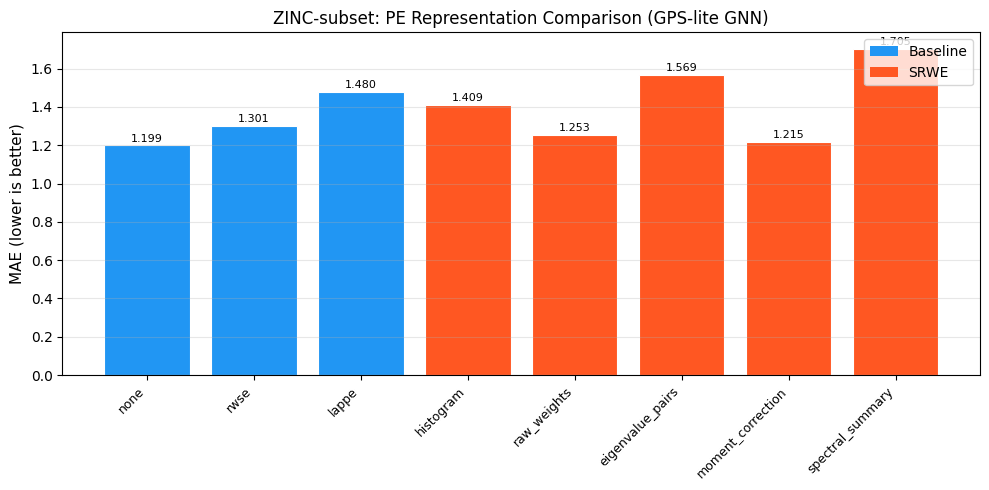


Spectral Consistency Check:
  Mean relative error: 5.47e-07
  Max relative error:  2.60e-05
  Number of checks:    250

Best SRWE variant: moment_correction (MAE=1.2151)
RWSE baseline:     MAE=1.3007
Improvement over RWSE: 6.6%


In [12]:
# ── Results Table ──
print("=" * 60)
print("SRWE Feature Representation Screening Results (ZINC-subset)")
print("=" * 60)
print(f"{'PE Type':<25} {'MAE':>10}  {'Category':>12}")
print("-" * 60)

for pe_type in all_pe_types:
    mae = results_4A.get(pe_type, {}).get("MAE", float("nan"))
    cat = "Baseline" if pe_type in baseline_pe_types else "SRWE"
    print(f"{pe_type:<25} {mae:>10.4f}  {cat:>12}")

print("-" * 60)

# ── Bar Chart ──
fig, ax = plt.subplots(figsize=(10, 5))

pe_names = list(results_4A.keys())
mae_values = [results_4A[p].get("MAE", float("nan")) for p in pe_names]
colors = ["#2196F3" if p in baseline_pe_types else "#FF5722" for p in pe_names]

bars = ax.bar(range(len(pe_names)), mae_values, color=colors, edgecolor="white", linewidth=0.8)
ax.set_xticks(range(len(pe_names)))
ax.set_xticklabels(pe_names, rotation=45, ha="right", fontsize=9)
ax.set_ylabel("MAE (lower is better)", fontsize=11)
ax.set_title("ZINC-subset: PE Representation Comparison (GPS-lite GNN)", fontsize=12)

# Add value labels on bars
for bar, val in zip(bars, mae_values):
    if not math.isnan(val):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f"{val:.3f}", ha="center", va="bottom", fontsize=8)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor="#2196F3", label="Baseline"),
                   Patch(facecolor="#FF5722", label="SRWE")]
ax.legend(handles=legend_elements, loc="upper right")

ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("srwe_comparison.png", dpi=100, bbox_inches="tight")
plt.show()

# ── Consistency check summary ──
print(f"\nSpectral Consistency Check:")
print(f"  Mean relative error: {consistency['mean_relative_error']:.2e}")
print(f"  Max relative error:  {consistency['max_relative_error']:.2e}")
print(f"  Number of checks:    {consistency['n_checks']}")

# ── Best variant ──
best_srwe = min(
    [(p, results_4A[p].get("MAE", float("inf"))) for p in srwe_pe_types],
    key=lambda x: x[1]
)
rwse_mae = results_4A.get("rwse", {}).get("MAE", float("nan"))
print(f"\nBest SRWE variant: {best_srwe[0]} (MAE={best_srwe[1]:.4f})")
print(f"RWSE baseline:     MAE={rwse_mae:.4f}")
if not math.isnan(rwse_mae) and best_srwe[1] < rwse_mae:
    improvement = (rwse_mae - best_srwe[1]) / rwse_mae * 100
    print(f"Improvement over RWSE: {improvement:.1f}%")
else:
    print("Note: With minimal epochs, SRWE may not yet outperform RWSE.")